In [1]:
import numpy as np
import pandas as pd 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import seaborn as sns

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS, TSNE
from sklearn.preprocessing import scale, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Function to be used

In [2]:
def corre_act_ide(X, pred_k_1):
    t = pred_k_1.reshape(740, -1)
    X_with_label = np.concatenate((X, t), axis=1)
    X_label_sorted = X_with_label[X_with_label[:, -1].argsort()]
    X_sorted = np.delete(X_label_sorted, -1, 1)
    X_act_sim = cosine_similarity(X_sorted)
    # Construct ideal similarity
    np.sort(t)
    idea_sim = np.zeros((740, 740))
    for i in range(t.shape[0]):
        for j in range(i+1, t.shape[0]):
            if(t[i,] == t[j,]):
                idea_sim[j, i] = 1
    # Calculate correlation coefficient
    act = []
    ide = []
    for i in range(X_act_sim.shape[1]):
        for j in range(i+1, X_act_sim.shape[0]):
            act.append(X_act_sim[j, i])
            ide.append(idea_sim[j, i])
    cor_score = np.corrcoef(act, ide)
    return cor_score

In [3]:
# Regard "absence time" as the true labels
# This is for some supervised performance evaluation metrics
# X should be the raw data, which is exactly X
def supervised_metrics(pred_labels):
    n = pred_labels.shape[0]
#     df = pd.DataFrame(X)
    lab = list(range(n))
#     true_labels = pd.cut(X.iloc[:, -1], bins=n, labels=lab, include_lowest=True)
    kbd = KBinsDiscretizer(n_bins=n, encode="ordinal", strategy="quantile")
    true_labels = np.array(list(kbd.fit_transform(X[:, -1].reshape(-1, 1)).flatten()))
    rand_score = adjusted_rand_score(true_labels, pred_labels)
    nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
    
    return rand_score, nmi_score

In [4]:
def hierarchy_cpcc(X, method="single"):
    coph_dis_list = sch.cophenet(sch.linkage(X, method=method))
    X_distance_list = pdist(X)
    cpcc = np.corrcoef(coph_dis_list, X_distance_list)
    return cpcc

In [5]:
def detail_each_cluster(labels):
    lab = pd.Series(labels, index = raw_data.index)
    df = pd.concat([raw_data, lab], axis=1)
    df.columns = list(raw_data.columns) + ["cluster label"]
    df_groupby_label = df.groupby("cluster label").mean()
    return df_groupby_label

# Plot functions

In [6]:
def plot_silhouette(X, cluster_labels):
    n_clusters = len(set(cluster_labels))
    # Compute silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    # Compute silhouette value for each data point
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
#    fig, ax = plt.subplot()
#    fig = plt.figure()
    ax = plt.gca()
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [7]:
def plot_basis(X, cluster_labels, centroids=None, x_index=0, y_index=1,
               title="Cluster plot"):
    plt.figure()
    plt.scatter(X[:, x_index], X[:, y_index], c=cluster_labels)
    if(centroids is not None):
        plt.scatter(centroids[:, x_index], centroids[:, y_index],
                marker='x', s=169, linewidths=3, color='r', zorder=10)
    plt.title(title)
    plt.show()

In [8]:
def plot_mds(X, cluster_labels, title="MDS plot", r=1):
    mds = MDS(n_components=2, eps=1e-12, random_state=r)
    d = mds.fit_transform(X)
#     d = mds.embedding_
    plt.scatter(d[:, 0], d[:, 1], s=20, c=cluster_labels, cmap = "nipy_spectral", edgecolor = "None")
    plt.colorbar()
    plt.title("MDS plot")
    plt.show()
    
#     mds_df = pd.DataFrame(np.c_[d, cluster_labels],columns=['x_axis','y_axis','cluster'])
#     sns.set(rc={'figure.figsize':(6,5)})
#     ax = sns.scatterplot(x="x_axis", y="y_axis", hue='cluster', style='cluster',palette="Set2",data=mds_df)
    

In [9]:
def plot_tsne(X, labels):
    tsne = TSNE()
    d = tsne.fit_transform(X)
#     d = tsne.embedding_
    plt.scatter(d[:, 0], d[:, 1], s=20, c=labels, cmap = "nipy_spectral", edgecolor = "None")
    plt.title("TSNE plot")
    plt.show()

In [10]:
def plot_dendrogram(X, method="ward", truncate_mode=None, title="Dendrogram"):
    plt.figure()
    h_d = sch.dendrogram(sch.linkage(X, method=method),
                         truncate_mode=truncate_mode)
    plt.title(title)
    plt.show()

In [11]:
def plot_knn_distance(X, k=5, title="KDD distance"):
    nn_c = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nn_c.kneighbors(X)
#     k_dis = np.sum(distances, axis=1)/(k -1)
    k_dis = np.amax(distances, axis=1)
    k_dis = np.sort(k_dis)
    plt.figure()
    plt.plot(k_dis)
    plt.ylabel("Distance")
    plt.xlabel("Number of data")
    plt.title(title)
    plt.show()

In [12]:
def plot_dbscan(X, dbscan):
    labels = dbscan.labels_
    n_cluster = len(set(labels)) - (1 if -1 in labels else 0)
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
    
        class_member_mask = (labels == k)
    
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
    
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    
    plt.title('DBSCAN: estimat number of clusters - %d ' % n_cluster)
    plt.show()

In [13]:
def plot_k_elbow(X, max_k):
    see = np.zeros((20, max_k-1))
    for j in range(20):
        for i in range(2, (max_k+1)):
            kmeans = KMeans(n_clusters=i, random_state=j).fit(X)
            see[j,i-2] = kmeans.inertia_
    see = np.mean(see, axis=0)
    plt.plot(np.arange(2, max_k+1), see, marker="o")
    plt.xlabel("K")
    plt.ylabel("SEE")
    plt.title("Choosing Optimal K with SEE")
    plt.show()

In [14]:
def plot_k_with_silhouette(X, max_k):
    sil_score = np.zeros((20, max_k-1))
    for j in range(20):
        for i in range(2, (max_k+1)):
            pred = KMeans(n_clusters=i, random_state=j).fit_predict(X)
#             sil_score.append(silhouette_score(X, pred))
            sil_score[j, i-2] = silhouette_score(X, pred)
    sil_score = np.mean(sil_score, axis=0)
    plt.plot(np.arange(2, max_k+1), sil_score, marker="o")
    plt.xlabel("K")
    plt.ylabel("Silhouette Score")
    plt.title("Choosing Optimal K with Silhouette Score")
    plt.show()

In [15]:
def plot_sim_matrix(X, labels):
    t = labels.reshape(740, -1)
    X_with_label = np.concatenate((X, t), axis=1)
    X_label_sorted = X_with_label[X_with_label[:, -1].argsort()]
    X_sorted = np.delete(X_label_sorted, -1, 1)
    X_act_sim = cosine_similarity(X_sorted)
    # cmap="hot", "coolwarm", plt.cm.gnuplot2
    plt.imshow(X_act_sim, cmap=plt.cm.gnuplot2, interpolation='nearest')
    plt.colorbar()
    plt.show()

# Load and preprocess data 

In [16]:
raw_data = pd.read_csv("Absenteeism_at_work.csv", sep=";")
for i in range(len(raw_data["Reason for absence"])):
    if(raw_data["Reason for absence"][i]>21):
        raw_data["Reason for absence"][i] = 2
    elif(raw_data["Reason for absence"][i]<1):
        raw_data["Reason for absence"][i] = 0
    else:
        raw_data["Reason for absence"][i] = 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
# Encode reason
pd.set_option('display.max_columns', 500)
dum = pd.get_dummies(raw_data["Reason for absence"])
tem = raw_data["Absenteeism time in hours"]
raw_data1 = raw_data.drop(["Reason for absence", "Absenteeism time in hours"], axis=1)
raw_data1 = pd.concat([raw_data1, dum, tem], axis=1)
raw_data1.head()

,ID,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,0,1,2,Absenteeism time in hours
0,11,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,0,0,1,4
1,36,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,1,0,0,0
2,3,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,0,0,1,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,0,1,0,4
4,11,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,0,0,1,2


In [18]:
X = raw_data1.values
# Pre-process data before clustering: scale data, (x-mean)/std
# X_nor = scale(X)
# Normalize data by hand
n_sample = X.shape[0]
m_feature = X.shape[1]
X_nor = np.zeros((n_sample, m_feature))
for i in range(m_feature):
    X_nor[:, i] = (X[:, i] - np.mean(X[:, i]))/np.std(X[:, i])


# # Pre-process data before clustering: PCA
# X_pca = PCA(n_components=2).fit_transform(X_nor)

# Pre-process data before clustering: 
# Remove ID, Weight, Height
X_removed_nor = np.delete(X_nor, [0, 16, 17], 1)
# PCA after removing ID, Weight, Height
X_pca = PCA(n_components=2).fit_transform(X_removed_nor)
# Also remove last column: absence time, for doing supervised evaluation
X_supervised = np.delete(X_removed_nor, -1, 1)

# K means 

### use raw data

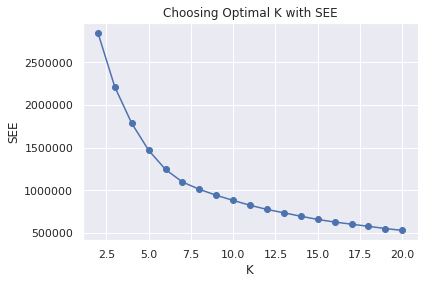

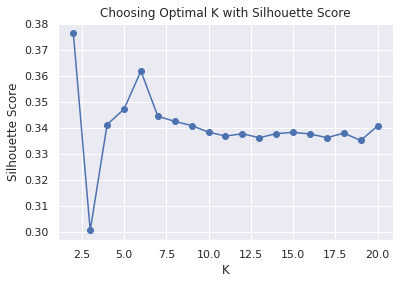

In [19]:
# Find optimal number of clusters
plot_k_elbow(X, 20)
plot_k_with_silhouette(X, 20)

In [20]:
# According to plot, choose 6 clusters
k_1 = KMeans(n_clusters=6, init="k-means++", n_init=20, max_iter=300, 
             tol=0.0001, precompute_distances="auto", verbose=0,
             random_state=1, copy_x=True, algorithm="auto")
pred_k_1 = k_1.fit_predict(X)
# plot_basis(X, pred_k_1, k_1.cluster_centers_, title="K-means clustering")
print("SEE: ", k_1.inertia_)
print("% instances per cluster: ", np.bincount(pred_k_1)/len(pred_k_1))

SEE:  1242504.5888747314
% instances per cluster:  [0.21621622 0.13108108 0.35135135 0.08783784 0.08918919 0.12432432]


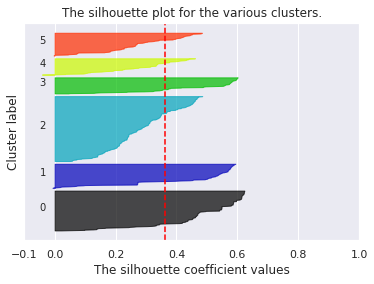

Silhouette Score:  0.3624279805976034


In [21]:
# Compute silhouette score
k_1_sil_score = silhouette_score(X, pred_k_1)
plot_silhouette(X, pred_k_1)
print("Silhouette Score: ", k_1_sil_score)

In [22]:
# t = pred_k_1.reshape(740, -1)
# X_with_label = np.concatenate((X, t), axis=1)
# X_label_sorted = X_with_label[X_with_label[:, -1].argsort()]
# X_sorted = np.delete(X_label_sorted, -1, 1)
# X_act_sim = cosine_similarity(X_sorted)
# # Construct ideal similarity
# np.sort(t)
# idea_sim = np.zeros((740, 740))
# for i in range(t.shape[0]):
#     for j in range(i+1, t.shape[0]):
#         if(t[i,] == t[j,]):
#             idea_sim[j, i] = 1
# # Calculate correlation coefficient
# act = []
# ide = []
# for i in range(X_act_sim.shape[1]):
#     for j in range(i+1, X_act_sim.shape[0]):
#         act.append(X_act_sim[j, i])
#         ide.append(idea_sim[j, i])
# cor_score = np.corrcoef(act, ide)
# print(cor_score)

# correlation coefficient between acutal similarity matrix and ideal similarity matrix
corre_act_ide(X, pred_k_1)

array([[1.       , 0.0601557],
       [0.0601557, 1.       ]])

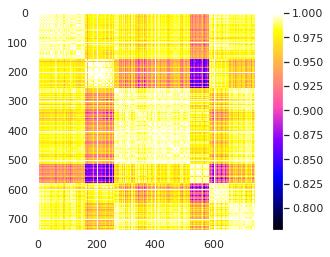

In [23]:
# Similarity matrix visualization
plot_sim_matrix(X, pred_k_1)

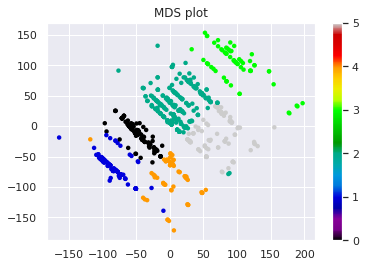

In [24]:
# MDS Plot
plot_mds(X, pred_k_1, title="MDS plot", r=1)

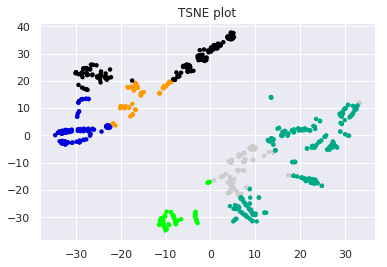

In [25]:
# TSNE plot
plot_tsne(X, pred_k_1)

In [140]:
# Check detail of each cluster
detail_k_1 = detail_each_cluster(pred_k_1)
detail_k_1.iloc[:, [1, 5, 6, 7, 12, 17, 18, 20]]

,Reason for absence,Transportation expense,Distance from Residence to Work,Service time,Education,Weight,Height,Absenteeism time in hours
cluster label,,,,,,,,
0,1.706250,178.400000,41.243750,15.056250,1.531250,78.006250,170.856250,4.543750
1,1.505155,122.577320,11.257732,13.123711,1.000000,88.804124,176.742268,8.762887
2,1.511538,251.565385,28.607692,12.015385,1.315385,77.523077,170.284615,6.615385
3,1.415385,359.030769,33.538462,6.569231,1.230769,76.584615,174.138462,8.353846
4,1.454545,167.212121,28.060606,14.303030,1.409091,79.666667,177.060606,8.500000
5,1.434783,256.195652,30.065217,12.097826,1.076087,76.076087,169.619565,7.858696


### with normalized data (no more run)

In [27]:
# # Find optimal K
# plot_k_elbow(X_nor, 15)
# plot_k_with_silhouette(X_nor, 15)

In [28]:
# # Choose 13 clusters according silhouette score
# k_3 = KMeans(n_clusters=13, n_init=20, random_state=1)
# pred_k_3 = k_3.fit_predict(X_nor)
# print("SEE: ", k_3.inertia_)
# print("% instances per cluster: ", np.bincount(pred_k_3)/len(pred_k_3))

In [29]:
# # Compute silhouette score
# k_3_sil_score = silhouette_score(X_nor, pred_k_3)
# plot_silhouette(X_nor, pred_k_3)
# print("Silhouette Score: ", k_3_sil_score)

In [30]:
# # correlation coefficient between acutal similarity matrix and ideal similarity matrix
# corre_act_ide(X_nor, pred_k_3)

In [31]:
# # Similarity matrix visualization
# plot_sim_matrix(X_nor, pred_k_3)

In [32]:
# # Supervised performance evaluation
# r_score_k_3, nmi_k_3 = supervised_metrics(raw_data, pred_k_3)
# print(r_score_k_3)
# print(nmi_k_3)

In [33]:
# # MDS plot
# plot_mds(X_nor, pred_k_3)

In [34]:
# # TSNE plot
# plot_tsne(X_nor, pred_k_3)

### with X_removed_nor data

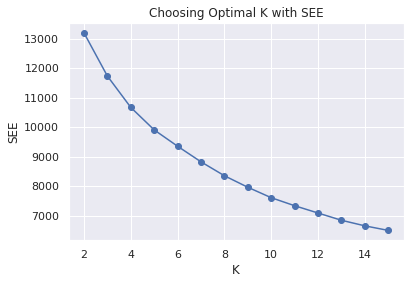

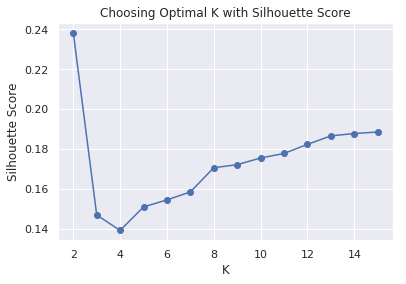

In [35]:
# Find optimal K
plot_k_elbow(X_removed_nor, 15)
plot_k_with_silhouette(X_removed_nor, 15)

In [36]:
# choose 8 clusters according to the plots
k_2 = KMeans(n_clusters=8, n_init=20, max_iter=500, random_state=1)
pred_k_2 = k_2.fit_predict(X_removed_nor)
print("SEE: ", k_2.inertia_)
print("% instances per cluster: ", np.bincount(pred_k_2)/len(pred_k_2))

SEE:  8279.114744682454
% instances per cluster:  [0.13513514 0.13243243 0.05675676 0.20945946 0.06216216 0.17162162
 0.18918919 0.04324324]


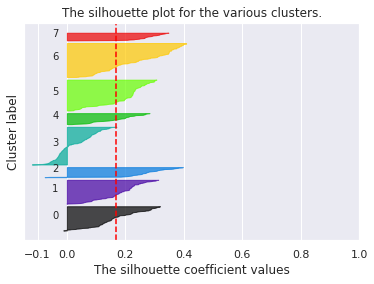

Silhouette Score:  0.16934406899178933


In [37]:
# Compute silhouette score
k_2_sil_score = silhouette_score(X_removed_nor, pred_k_2)
plot_silhouette(X_removed_nor, pred_k_2)
print("Silhouette Score: ", k_2_sil_score)

In [38]:
# correlation coefficient between acutal similarity matrix and ideal similarity matrix
corre_act_ide(X_removed_nor, pred_k_2)

array([[1.        , 0.01943968],
       [0.01943968, 1.        ]])

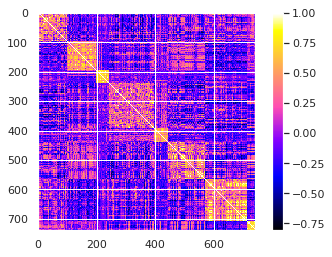

In [39]:
# Similarity matrix visualization
plot_sim_matrix(X_removed_nor, pred_k_2)

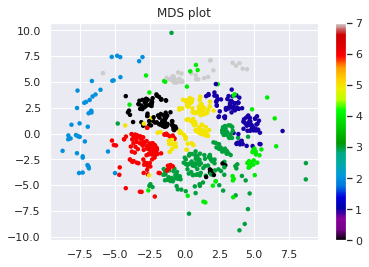

In [40]:
# Plot MDS
plot_mds(X_removed_nor, pred_k_2)

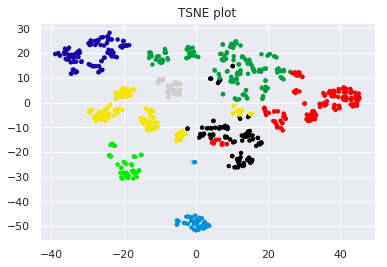

In [41]:
# Plot TSNE
plot_tsne(X_removed_nor, pred_k_2)

In [42]:
# Detail of each cluster centroid
detail_k_2 = detail_each_cluster(pred_k_2)
detail_k_2

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,16.530000,1.910000,7.620000,4.550000,2.600000,282.970000,36.570000,12.020000,36.430000,266.440540,93.440000,0.000000,1.000000,2.460000,0.960000,0.000000,0.520000,74.200000,170.210000,25.560000,4.800000
1,17.285714,1.530612,5.959184,4.071429,2.479592,222.551020,19.428571,9.530612,32.000000,261.957235,95.357143,0.000000,2.877551,0.306122,0.040816,0.000000,0.306122,71.142857,174.102041,23.204082,5.826531
2,18.380952,0.000000,7.500000,3.880952,3.214286,249.666667,26.785714,12.619048,39.595238,275.991000,92.380952,0.952381,1.119048,1.357143,0.666667,0.190476,0.880952,83.190476,171.880952,28.190476,0.000000
3,20.574194,1.000000,6.264516,3.606452,2.651613,211.677419,25.883871,13.290323,37.864516,286.631394,94.412903,0.000000,1.000000,1.083871,0.612903,0.000000,0.554839,80.929032,173.064516,27.000000,17.122581
4,18.108696,1.413043,5.630435,4.065217,2.173913,221.826087,24.847826,14.086957,39.326087,270.936391,95.391304,0.000000,1.434783,1.652174,0.369565,1.000000,0.978261,69.434783,172.369565,23.478261,7.630435
5,27.535433,2.000000,5.897638,3.724409,2.574803,186.692913,20.496063,10.456693,33.590551,281.536819,95.283465,0.000000,1.000000,0.929134,0.102362,0.000000,1.039370,76.740157,172.125984,25.881890,2.952756
6,9.764286,1.907143,5.835714,3.892857,2.357143,186.100000,41.885714,17.828571,40.414286,256.901071,94.828571,0.000000,1.000000,0.192857,0.964286,0.000000,0.071429,90.157143,170.750000,31.042857,3.378571
7,10.250000,1.562500,6.968750,3.625000,2.406250,325.406250,50.593750,2.875000,29.031250,261.969469,94.593750,0.000000,1.218750,1.000000,1.000000,0.000000,5.000000,77.937500,173.250000,25.906250,6.875000


### with X_supervised data

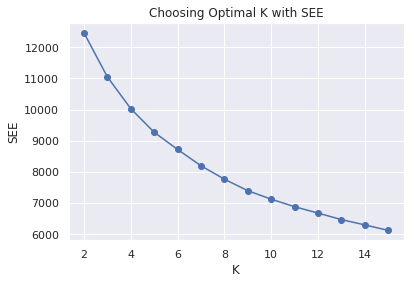

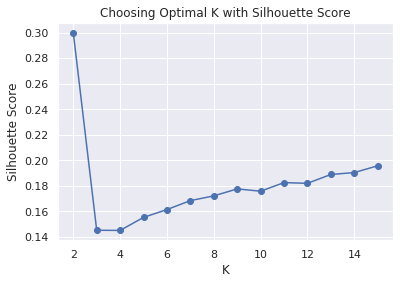

In [43]:
# Find optimal k
plot_k_elbow(X_supervised, 15)
plot_k_with_silhouette(X_supervised, 15)

In [44]:
# choose 8 clusters based on silhouette score
k_5 = KMeans(n_clusters=8, n_init=20, random_state=1)
pred_k_5 = k_5.fit_predict(X_supervised)
print("SEE: ", k_5.inertia_)
print("% instances per cluster: ", np.bincount(pred_k_5)/len(pred_k_5))

SEE:  7707.767625201119
% instances per cluster:  [0.06216216 0.04324324 0.15540541 0.12297297 0.18108108 0.05405405
 0.20540541 0.17567568]


In [45]:
# k_5_sil_score = silhouette_score(X_supervised, pred_k_5)
# plot_silhouette(X_supervised, pred_k_5)
# print("Silhouette Score: ", k_5_sil_score)

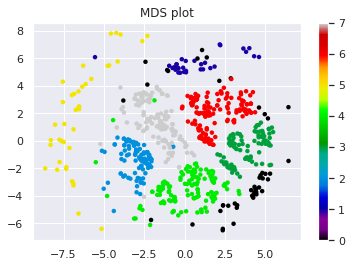

In [46]:
# Plot MDS
plot_mds(X_supervised, pred_k_5)

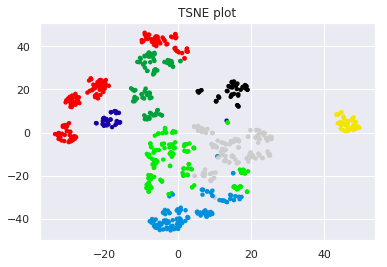

In [47]:
# Plot TSNE
plot_tsne(X_supervised, pred_k_5)

In [48]:
# # correlation coefficient between acutal similarity matrix and ideal similarity matrix
# corre_act_ide(X_supervised, pred_k_5)

In [49]:
# # Similarity matrix visualization
# plot_sim_matrix(X_supervised, pred_k_5)

In [50]:
# Supervised performance evaluation
r_score_k_5, nmi_k_5 = supervised_metrics(pred_k_5)
print(r_score_k_5)
print(nmi_k_5)

0.09623868169523277
0.22054653944239722


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [51]:
# Detail of each cluster
detail_k_5 = detail_each_cluster(pred_k_5)
detail_k_5

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,18.108696,1.413043,5.630435,4.065217,2.173913,221.826087,24.847826,14.086957,39.326087,270.936391,95.391304,0.0,1.434783,1.652174,0.369565,1.0,0.978261,69.434783,172.369565,23.478261,7.630435
1,10.250000,1.562500,6.968750,3.625000,2.406250,325.406250,50.593750,2.875000,29.031250,261.969469,94.593750,0.0,1.218750,1.000000,1.000000,0.0,5.000000,77.937500,173.250000,25.906250,6.875000
2,8.452174,2.000000,5.843478,3.947826,2.478261,177.878261,42.739130,17.739130,40.321739,258.082304,95.060870,0.0,1.000000,0.226087,0.982609,0.0,0.034783,91.869565,170.886957,31.626087,3.156522
3,23.109890,1.000000,6.318681,3.670330,2.692308,202.791209,19.461538,9.461538,32.043956,273.176604,94.956044,0.0,1.923077,0.450549,0.021978,0.0,0.681319,73.472527,172.384615,24.560440,9.373626
4,16.552239,0.985075,6.216418,3.694030,2.500000,227.858209,31.514925,15.104478,39.985075,285.468284,94.447761,0.0,1.000000,1.328358,0.858209,0.0,0.350746,83.440299,173.492537,27.768657,17.350746
5,18.225000,0.000000,7.875000,3.825000,3.250000,251.900000,26.125000,12.550000,39.275000,276.229600,92.250000,1.0,1.125000,1.350000,0.675000,0.2,0.850000,82.925000,171.850000,28.100000,0.000000
6,24.986842,2.000000,6.013158,4.013158,2.546053,194.217105,20.782895,9.546053,31.631579,270.757263,95.118421,0.0,1.657895,0.526316,0.013158,0.0,0.881579,72.263158,171.151316,24.513158,3.342105
7,18.092308,2.000000,6.838462,4.215385,2.492308,262.515385,31.169231,12.861538,38.038462,269.700792,93.869231,0.0,1.000000,2.053846,0.861538,0.0,0.507692,77.423077,172.430769,26.069231,3.876923


### with pca data

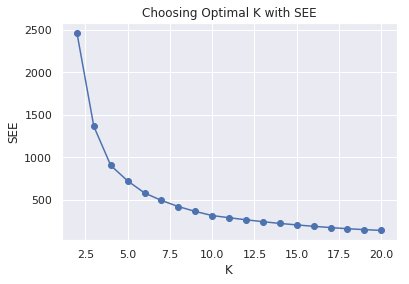

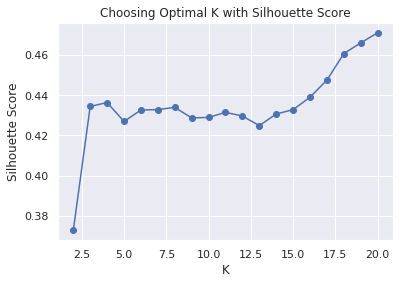

In [52]:
# Find optimal K
plot_k_elbow(X_pca, 20)
plot_k_with_silhouette(X_pca, 20)

In [53]:
# choose 6 clusters based elbow
k_4 = KMeans(n_clusters=6, n_init=20, max_iter=500, random_state=1)
pred_k_4 = k_4.fit_predict(X_pca)
print("SEE: ", k_4.inertia_)
print("% instances per cluster: ", np.bincount(pred_k_4)/len(pred_k_4))

SEE:  581.4251081628443
% instances per cluster:  [0.12297297 0.20810811 0.05405405 0.17702703 0.22432432 0.21351351]


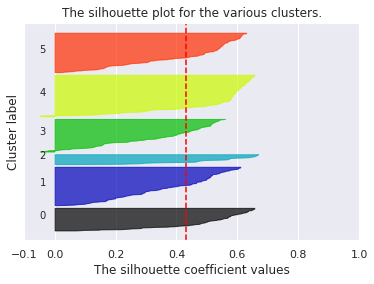

Silhouette Score:  0.432645904503913


In [54]:
k_4_sil_score = silhouette_score(X_pca, pred_k_4)
plot_silhouette(X_pca, pred_k_4)
print("Silhouette Score: ", k_4_sil_score)

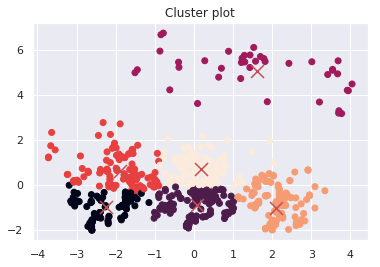

In [55]:
# Plot with centroids
plot_basis(X_pca, pred_k_4, k_4.cluster_centers_)

In [56]:
# correlation coefficient between acutal similarity matrix and ideal similarity matrix
corre_act_ide(X_pca, pred_k_4)

array([[1.        , 0.00994415],
       [0.00994415, 1.        ]])

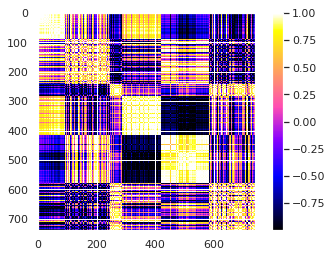

In [57]:
# Similarity matrix visualization
plot_sim_matrix(X_pca, pred_k_4)

In [58]:
# Detail of each cluster
detail_k_4 = detail_each_cluster(pred_k_4)
detail_k_4

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,23.472527,1.802198,3.945055,4.208791,2.175824,210.846154,24.967033,8.571429,29.395604,275.179330,96.142857,0.0,2.153846,0.351648,0.010989,0.010989,0.670330,64.923077,171.637363,21.923077,3.637363
1,21.396104,1.857143,5.045455,3.857143,2.116883,197.883117,20.136364,12.655844,37.571429,266.243591,95.616883,0.0,1.233766,1.123377,0.487013,0.058442,0.383117,81.058442,174.435065,26.590909,4.785714
2,18.225000,0.000000,7.875000,3.825000,3.250000,251.900000,26.125000,12.550000,39.275000,276.229600,92.250000,1.0,1.125000,1.350000,0.675000,0.200000,0.850000,82.925000,171.850000,28.100000,0.000000
3,19.908397,1.366412,7.450382,3.778626,2.847328,259.534351,30.732824,8.099237,30.679389,271.955366,94.671756,0.0,1.488550,0.961832,0.297710,0.129771,2.145038,72.519084,172.389313,24.282443,7.877863
4,10.740964,1.734940,6.012048,3.861446,2.433735,178.481928,40.512048,17.861446,41.126506,265.653060,94.662651,0.0,1.000000,0.325301,0.945783,0.012048,0.084337,92.018072,171.096386,31.596386,5.596386
5,17.607595,1.360759,7.943038,3.993671,2.860759,255.822785,30.113924,12.867089,38.575949,279.026563,93.132911,0.0,1.037975,1.993671,0.765823,0.107595,0.651899,75.968354,171.037975,25.955696,13.259494


# Hierarchy clustering

### with raw data

#### complete (max)

In [106]:
# linkage = {"single", "complete", "average", "ward"}
# complete(max)
h_1 = AgglomerativeClustering(n_clusters=6, affinity="euclidean", 
                              memory=None, connectivity=None,
                              compute_full_tree="auto", linkage="complete")
t_h_1 = datetime.now()
pred_h_1 = h_1.fit_predict(X)
t_h_2 = datetime.now()
print("Time taken: ", (t_h_2 - t_h_1).microseconds/100000 + (t_h_2 - t_h_1).seconds)
# % of instances per cluster
print("% instances per cluster: ", np.bincount(h_1.labels_)/len(h_1.labels_))

Time taken:  0.15295
% instances per cluster:  [0.51216216 0.25540541 0.04864865 0.07162162 0.06756757 0.04459459]


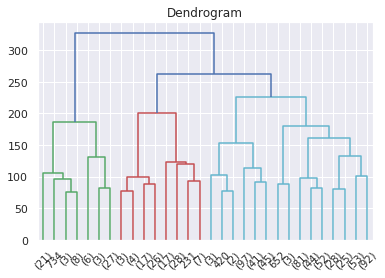

In [107]:
# dendrogram plot
# truncate_mode = {None, lastp, level}
plot_dendrogram(X, method="complete", truncate_mode="lastp")

In [108]:
# # performance evaluation matrics: Cophenetic correlation coefficient
# # calculate cophenetic distance matrix
# coph_dis_h_1 = sch.cophenet(sch.linkage(X, method="single"))
# # calculate flatten distance matrix
# # from sklearn.metrics.pairwise import euclidean_distances
# # X_distance_matrix = euclidean_distances(X)
# from scipy.spatial.distance import pdist
# X_distance_list = pdist(X)
# # print(X_distance_matrix[:10, :10])
# # print(np.allclose(X_distance_matrix, X_distance_matrix.T))
# # use only left bottom triangle matrix since it is symetrical
# # from scipy.spatial.distance import squareform
# # X_distance_vector = squareform(X_distance_matrix)
# # calculate correlation coefficient
# h_1_cpcc = np.corrcoef(coph_dis_h_1, X_distance_list)
# print(h_1_cpcc)
print(hierarchy_cpcc(X, method="complete"))

[[1.        0.6891005]
 [0.6891005 1.       ]]


In [109]:
# correlation coefficient between acutal similarity matrix and ideal similarity matrix
corre_act_ide(X, pred_h_1)

array([[ 1.        , -0.05564039],
       [-0.05564039,  1.        ]])

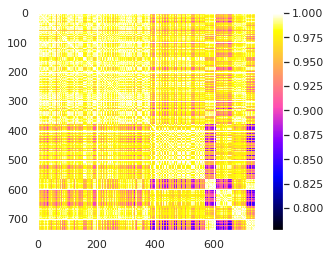

In [110]:
# Similarity matrix visualization
plot_sim_matrix(X, pred_h_1)

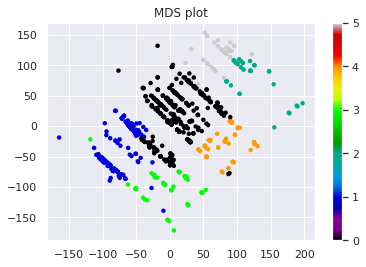

In [111]:
# Plot MDS
plot_mds(X, pred_h_1)

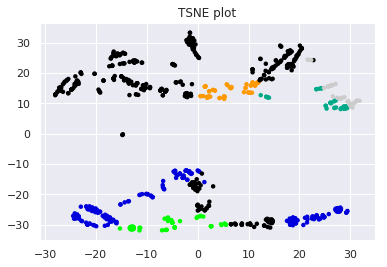

In [112]:
# Plot tsne
plot_tsne(X, pred_h_1)

In [113]:
detail_each_cluster(pred_h_1)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,17.385224,1.540897,6.968338,4.044855,2.551451,236.218997,31.013193,12.461741,36.451187,265.351528,94.060686,0.058047,1.364116,1.221636,0.527704,0.052770,0.944591,76.606860,170.134565,26.437995,5.989446
1,19.211640,1.613757,6.338624,3.809524,2.460317,153.597884,28.015873,14.465608,38.137566,246.839995,95.306878,0.042328,1.259259,0.433862,0.603175,0.089947,0.074074,83.608466,173.947090,27.740741,6.862434
2,16.138889,1.388889,7.861111,3.527778,3.055556,361.833333,33.638889,7.027778,31.833333,295.905722,94.166667,0.138889,1.194444,1.333333,0.555556,0.166667,2.000000,75.722222,174.111111,24.916667,6.277778
3,20.754717,1.490566,3.377358,3.471698,2.509434,148.415094,20.943396,14.000000,37.566038,337.287943,94.849057,0.000000,1.132075,0.849057,0.641509,0.075472,0.000000,86.962264,179.660377,27.132075,8.283019
4,19.140000,1.380000,3.720000,4.200000,2.580000,256.240000,29.680000,12.460000,36.260000,345.567520,95.380000,0.040000,1.120000,1.500000,0.600000,0.080000,0.980000,75.120000,169.360000,26.040000,8.780000
5,14.393939,1.363636,5.848485,3.727273,2.393939,349.181818,32.515152,6.515152,30.303030,238.622515,95.363636,0.090909,1.272727,1.242424,0.666667,0.090909,1.787879,77.545455,174.242424,25.484848,13.727273


### with normalized data ( no more run)
### with X_supervised data

In [114]:
# single
h_3 = AgglomerativeClustering(n_clusters=8, affinity="euclidean", 
                              memory=None, connectivity=None,
                              compute_full_tree="auto", linkage="single")
t_h_3_1 = datetime.now()
pred_h_3 = h_3.fit_predict(X_supervised)
t_h_3_2 = datetime.now()
print("Time taken: ", (t_h_3_2 - t_h_3_1).microseconds/100000 + (t_h_3_2 - t_h_3_1).seconds)
# % of instances per cluster
print("% instances per cluster: ", np.bincount(h_3.labels_)/len(h_3.labels_))

Time taken:  0.09464
% instances per cluster:  [0.94189189 0.0027027  0.04324324 0.0027027  0.00405405 0.00135135
 0.0027027  0.00135135]


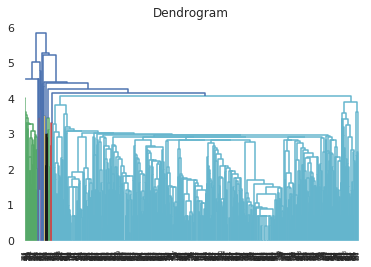

In [68]:
# dendrogram plot
# truncate_mode = {None, lastp, level}
plot_dendrogram(X_supervised, method="single")

In [69]:
# CPCC
hierarchy_cpcc(X_supervised, method="single")

array([[1.        , 0.78761799],
       [0.78761799, 1.        ]])

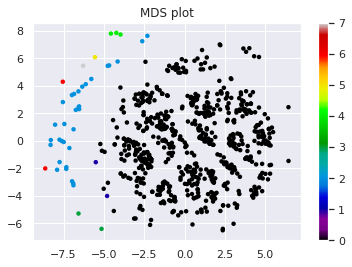

In [115]:
# Plot MDS
plot_mds(X_supervised, pred_h_3)

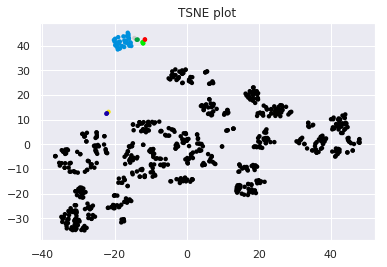

In [116]:
# Plot tsne
plot_tsne(X_supervised, pred_h_3)

In [117]:
# Supervised metrics
rand_score_h_3, nmi_h_3 = supervised_metrics(pred_h_3)
print(rand_score_h_3)
print(nmi_h_3)

0.04612946234165287
0.2856498631821124


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [130]:
detail_each_cluster(pred_h_3)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,18.015782,1.624103,6.262554,3.918221,2.506456,219.770445,29.824964,12.549498,36.25538,271.219416,94.72023,0.0,1.302726,0.998565,0.560976,0.065997,0.727403,78.757532,172.131994,26.575323,7.351506
1,21.500000,0.000000,0.000000,5.000000,2.500000,205.000000,40.000000,14.000000,46.00000,271.219000,95.00000,0.0,1.000000,1.500000,0.500000,0.000000,1.500000,88.500000,172.500000,30.000000,0.000000
2,19.125000,0.000000,8.062500,3.906250,3.218750,242.406250,25.093750,12.843750,39.37500,269.348125,91.65625,1.0,1.156250,1.312500,0.750000,0.000000,0.375000,85.468750,172.031250,28.906250,0.000000
3,7.000000,0.000000,8.000000,3.500000,3.500000,279.000000,5.000000,14.000000,39.00000,331.457500,94.50000,1.0,1.000000,2.000000,1.000000,1.000000,0.000000,68.000000,168.000000,24.000000,0.000000
4,23.000000,0.000000,7.000000,4.666667,3.333333,378.000000,49.000000,11.000000,36.00000,300.190333,96.00000,1.0,1.000000,2.000000,0.000000,1.000000,4.000000,65.000000,174.000000,21.000000,0.000000
5,4.000000,0.000000,0.000000,3.000000,1.000000,118.000000,14.000000,13.000000,40.00000,271.219000,95.00000,0.0,1.000000,1.000000,1.000000,0.000000,8.000000,98.000000,170.000000,34.000000,0.000000
6,2.000000,0.000000,5.000000,2.000000,3.000000,235.000000,29.000000,12.000000,48.00000,300.770500,96.00000,1.0,1.000000,1.000000,0.000000,1.000000,5.000000,88.000000,163.000000,33.000000,0.000000
7,30.000000,0.000000,10.000000,3.000000,4.000000,157.000000,27.000000,6.000000,29.00000,265.017000,88.00000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,75.000000,185.000000,22.000000,0.000000


### with x_removed_nor data

#### Ward

In [73]:
# ward
h_4 = AgglomerativeClustering(n_clusters=3, affinity="euclidean", 
                              memory=None, connectivity=None,
                              compute_full_tree="auto", linkage="ward")
t_h_4_1 = datetime.now()
pred_h_4 = h_4.fit_predict(X_removed_nor)
t_h_4_2 = datetime.now()
print("Time taken: ", (t_h_4_2 - t_h_4_1).microseconds/100000 + (t_h_4_2 - t_h_4_1).seconds)
# % of instances per cluster
print("% instances per cluster: ", np.bincount(h_4.labels_)/len(h_4.labels_))

Time taken:  0.13618
% instances per cluster:  [0.59189189 0.05810811 0.35      ]


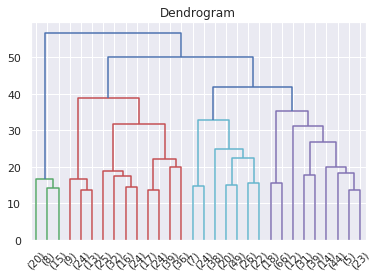

In [74]:
# dendrogram plot
# truncate_mode = {None, lastp, level}
plot_dendrogram(X_removed_nor, method="ward", truncate_mode="lastp")

In [75]:
# CPCC
hierarchy_cpcc(X_removed_nor, method="ward")

array([[1.        , 0.55346921],
       [0.55346921, 1.        ]])

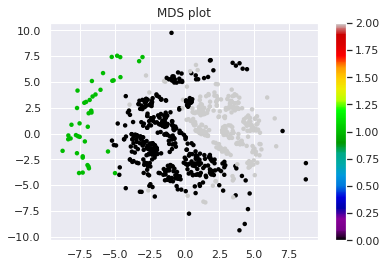

In [76]:
# Plot MDS
plot_mds(X_removed_nor, pred_h_4)

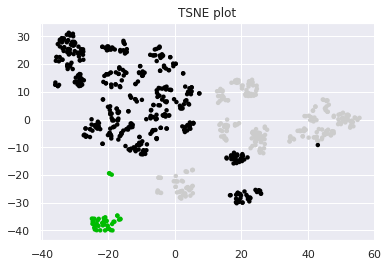

In [77]:
# Plot tsne
plot_tsne(X_removed_nor, pred_h_4)

In [127]:
detail_each_cluster(pred_h_4)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,15.125571,1.662100,6.723744,3.917808,2.579909,231.550228,35.317352,13.851598,37.915525,271.133100,94.438356,0.000000,1.020548,1.205479,0.844749,0.000000,0.730594,82.454338,172.189498,27.869863,8.636986
1,18.046512,0.000000,7.325581,3.860465,3.162791,246.604651,26.488372,12.627907,39.604651,275.880023,92.441860,0.930233,1.116279,1.348837,0.674419,0.186047,1.046512,83.534884,171.837209,28.325581,0.000000
2,22.903475,1.559846,5.482625,3.918919,2.382239,199.849421,20.536680,10.347490,33.447876,271.365386,95.196911,0.000000,1.779923,0.648649,0.081081,0.177606,0.722008,72.505792,172.034749,24.386100,5.177606


#### complete (max)

In [118]:
# complete(max)
h_5 = AgglomerativeClustering(n_clusters=8, affinity="euclidean", 
                              memory=None, connectivity=None,
                              compute_full_tree="auto", linkage="complete")
t_h_5_1 = datetime.now()
pred_h_5 = h_5.fit_predict(X_removed_nor)
t_h_5_2 = datetime.now()
print("Time taken: ", (t_h_5_2 - t_h_5_1).microseconds/100000 + (t_h_5_2 - t_h_5_1).seconds)
# % of instances per cluster
print("% instances per cluster: ", np.bincount(h_5.labels_)/len(h_5.labels_))

Time taken:  0.18249
% instances per cluster:  [0.71486486 0.01756757 0.06081081 0.01081081 0.04324324 0.10675676
 0.00405405 0.04189189]


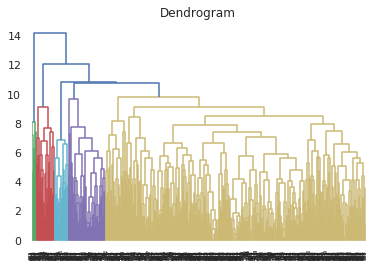

In [119]:
# dendrogram plot
# truncate_mode = {None, lastp, level}
plot_dendrogram(X_removed_nor, method="complete")#, truncate_mode="lastp")

In [120]:
# CPCC
hierarchy_cpcc(X_removed_nor, method="complete")

array([[1.        , 0.71396017],
       [0.71396017, 1.        ]])

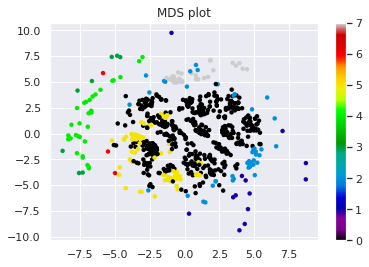

In [121]:
# Plot MDS
plot_mds(X_removed_nor, pred_h_5)

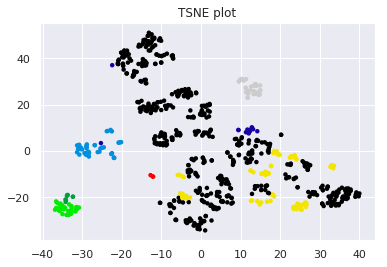

In [122]:
# Plot tsne
plot_tsne(X_removed_nor, pred_h_5)

In [128]:
detail_each_cluster(pred_h_5)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,18.648393,1.657845,5.911153,3.937618,2.408318,215.489603,28.827977,12.357278,35.383743,269.494473,94.867675,0.0,1.344045,0.996219,0.506616,0.000000,0.531191,77.839319,172.134216,26.234405,5.697543
1,22.000000,1.000000,7.615385,3.230769,2.692308,200.000000,17.615385,13.230769,40.230769,262.362615,95.692308,0.0,1.153846,1.384615,0.538462,0.076923,0.461538,80.307692,176.307692,25.769231,90.461538
2,17.933333,1.422222,5.644444,4.022222,2.155556,220.088889,24.822222,14.111111,39.244444,271.675956,95.311111,0.0,1.444444,1.644444,0.355556,1.000000,0.977778,69.266667,172.311111,23.444444,6.377778
3,14.625000,0.000000,7.125000,3.500000,3.375000,289.875000,30.250000,11.375000,38.875000,303.755500,94.625000,1.0,1.000000,1.500000,0.375000,1.000000,2.750000,72.750000,171.125000,24.875000,0.000000
4,19.125000,0.000000,8.062500,3.906250,3.218750,242.406250,25.093750,12.843750,39.375000,269.348125,91.656250,1.0,1.156250,1.312500,0.750000,0.000000,0.375000,85.468750,172.031250,28.906250,0.000000
5,16.139241,1.620253,8.379747,3.949367,3.354430,207.430380,32.746835,16.759494,42.708861,287.714190,93.291139,0.0,1.000000,0.582278,0.873418,0.000000,0.303797,90.632911,170.848101,31.139241,5.405063
6,15.666667,0.000000,0.000000,4.333333,2.000000,176.000000,31.333333,13.666667,44.000000,271.219000,95.000000,0.0,1.000000,1.333333,0.666667,0.000000,3.666667,91.666667,171.666667,31.333333,0.000000
7,10.451613,1.612903,7.193548,3.645161,2.451613,332.096774,51.774194,2.548387,28.677419,261.671097,94.580645,0.0,1.225806,1.000000,1.000000,0.000000,4.903226,77.290323,173.354839,25.645161,7.096774


### with X_pca data

In [123]:
# average
h_2 = AgglomerativeClustering(n_clusters=6, affinity="euclidean", 
                              memory=None, connectivity=None,
                              compute_full_tree="auto", linkage="average")
t_h_2_1 = datetime.now()
pred_h_2 = h_2.fit_predict(X_pca)
t_h_2_2 = datetime.now()
print("Time taken: ", (t_h_2_2 - t_h_2_1).microseconds/100000 + (t_h_2_2 - t_h_2_1).seconds)
# % of instances per cluster
print("% instances per cluster: ", np.bincount(h_2.labels_)/len(h_2.labels_))

Time taken:  0.09672
% instances per cluster:  [0.22972973 0.31621622 0.02162162 0.01351351 0.4        0.01891892]


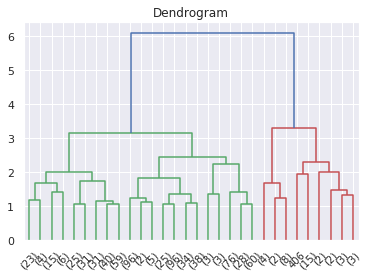

In [124]:
# dendrogram plot
# truncate_mode = {None, lastp, level}
plot_dendrogram(X_pca, method="average", truncate_mode="lastp")

In [125]:
# calculate correlation coefficient
print(hierarchy_cpcc(X_pca, method="average"))

[[1.         0.81767518]
 [0.81767518 1.        ]]


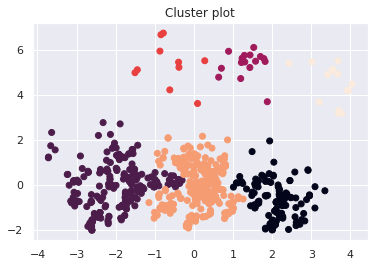

In [126]:
# Plot
plot_basis(X_pca, pred_h_2)

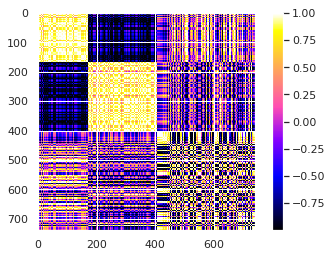

In [132]:
plot_sim_matrix(X_pca, pred_h_2)

In [129]:
detail_each_cluster(pred_h_2)

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
0,11.005882,1.711765,6.047059,3.882353,2.541176,179.217647,40.476471,17.782353,41.235294,266.505176,94.670588,0.0,1.000000,0.358824,0.929412,0.011765,0.111765,92.035294,171.041176,31.629412,5.558824
1,21.435897,1.534188,6.179487,3.927350,2.641026,236.021368,27.833333,8.487179,30.508547,272.982047,95.213675,0.0,1.735043,0.709402,0.175214,0.076923,1.487179,69.833333,171.952991,23.500000,6.269231
2,14.375000,0.000000,7.625000,3.375000,3.187500,289.437500,29.750000,12.250000,38.312500,280.821438,92.875000,1.0,1.000000,1.875000,0.812500,0.250000,0.875000,73.812500,169.187500,25.812500,0.000000
3,21.400000,0.000000,7.500000,3.500000,3.500000,290.400000,28.000000,8.700000,31.900000,287.430800,94.200000,1.0,1.500000,0.900000,0.100000,0.400000,1.700000,74.300000,175.900000,23.700000,0.000000
4,19.314189,1.628378,6.388514,3.935811,2.375000,229.770270,25.297297,12.766892,38.016892,272.533483,94.361486,0.0,1.131757,1.597973,0.655405,0.087838,0.510135,78.317568,172.895270,26.152027,9.162162
5,20.357143,0.000000,8.428571,4.571429,3.142857,181.500000,20.642857,15.642857,45.642857,262.980929,90.142857,1.0,1.000000,1.071429,0.928571,0.000000,0.214286,99.500000,172.000000,33.857143,0.000000


# DBSCAN

### with raw data

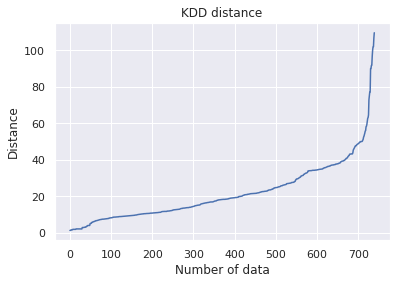

In [87]:
# Find optimal eps according to customized k using KNN distance
# k corresponds to min_sample
# eps should be the "knee" of knn distance plot

# Try k = 10
plot_knn_distance(X, k=10)

Time taken:  0.21677
% instances per cluster:  [0.47972973 0.11486486 0.30540541 0.05540541]
% of noise:  0.0445945945945946


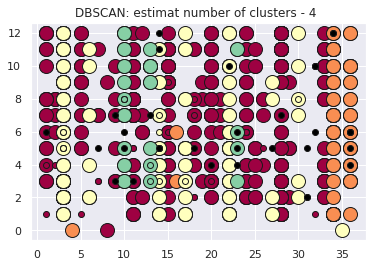

In [88]:
# choose eps = 40, min sample = 10
t1_d_1 = datetime.now()
d_1 = DBSCAN(eps=40, min_samples=10)
pred_d_1 = d_1.fit_predict(X)
t2_d_1 = datetime.now()
print("Time taken: ", (t2_d_1-t1_d_1).microseconds/100000 + (t2_d_1 - t1_d_1).seconds)
d_1_ls = np.array([x for x in pred_d_1 if x!=-1])
print("% instances per cluster: ", np.bincount(d_1_ls)/len(pred_d_1))
print("% of noise: ", (len(pred_d_1) - len(d_1_ls))/len(pred_d_1))
plot_dbscan(X, d_1)

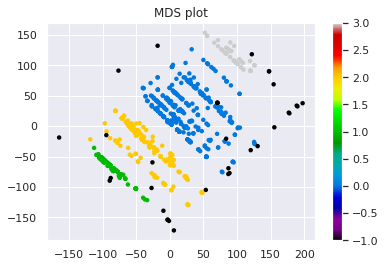

In [89]:
plot_mds(X, pred_d_1)

In [90]:
# For DBSCAN, I think we should first remove the instances which have been predicted as noise. After that, we can 
# calculte correlation coefficient, similarity matrix, and so on.
# Regard "absence time" as the true labels
# This is for some supervised performance evaluation metrics
# def supervised_metrics_dbscan(pred_labels):
#     X_db = X[pred_labels != -1, ]
#     n = pred_labels.shape[0] - 1
# #     df = pd.DataFrame(X)
# #     lab = list(range(n))
# #     true_labels = pd.cut(X.iloc[:, -1], bins=n, labels=lab, include_lowest=True)
#     kbd = KBinsDiscretizer(n_bins=n, encode="ordinal", strategy="quantile")
#     if(n!=1):
#         true_labels = list(kbd.fit_transform(X_db[:, -1].reshape(-1, 1)))
# #     true_labels = np.array(list(kbd.fit_transform(X_db[:, -1].reshape(-1, 1)).flatten()))
#     else:
#         true_labels = [0 for i in range(len(pred_labels[pred_labels!=-1]))]
#     rand_score = adjusted_rand_score(true_labels, pred_labels[pred_labels!=-1])
#     nmi_score = normalized_mutual_info_score(true_labels, pred_labels[pred_labels!=-1])
    
#     return rand_score, nmi_score

def plot_sim_matrix_dbscan(X, labels):
    t = labels[labels!=-1].reshape(-1, 1)
    X_with_label = np.concatenate((X[labels!=-1, ], t), axis=1)
    X_label_sorted = X_with_label[X_with_label[:, -1].argsort()]
    X_sorted = np.delete(X_label_sorted, -1, 1)
    X_act_sim = cosine_similarity(X_sorted)
    # cmap="hot", "coolwarm", plt.cm.gnuplot2
    plt.imshow(X_act_sim, cmap=plt.cm.gnuplot2, interpolation='nearest')
    plt.colorbar()
    plt.show()

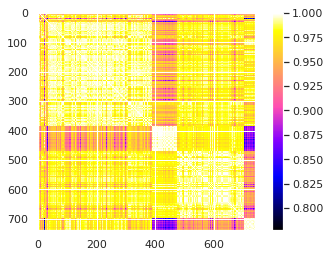

In [91]:
plot_sim_matrix(X, pred_d_1)

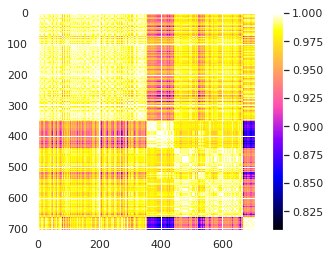

In [92]:
plot_sim_matrix_dbscan(X, pred_d_1)

### with X_removed_nor data

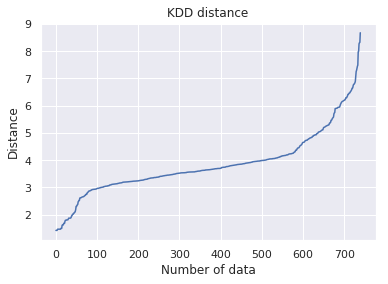

In [93]:
# Try k = 15
plot_knn_distance(X_removed_nor, k=30)

Time taken:  0.27054
% instances per cluster:  [0.84594595 0.03378378 0.02162162]
% of noise:  0.09864864864864865


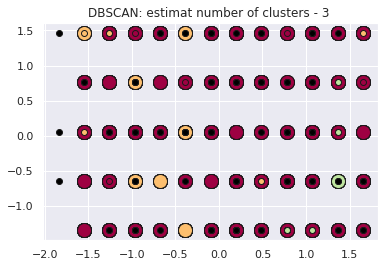

In [94]:
# choose eps=4, min sample=15
t1_d_3 = datetime.now()
d_3 = DBSCAN(eps=4, min_samples=15)
pred_d_3 = d_3.fit_predict(X_removed_nor)
t2_d_3 = datetime.now()
print("Time taken: ", (t2_d_3-t1_d_3).microseconds/100000 + (t2_d_3 - t1_d_3).seconds)
d_3_ls = np.array([x for x in pred_d_3 if x!=-1])
print("% instances per cluster: ", np.bincount(d_3_ls)/len(pred_d_3))
print("% of noise: ", (len(pred_d_3) - len(d_3_ls))/len(pred_d_3))
plot_dbscan(X_removed_nor, d_3)

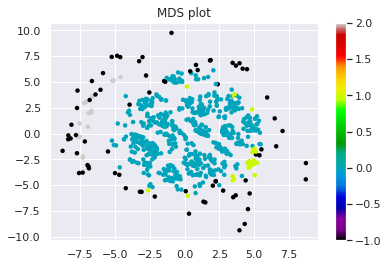

In [95]:
# Plot MDS
plot_mds(X_removed_nor, pred_d_3)

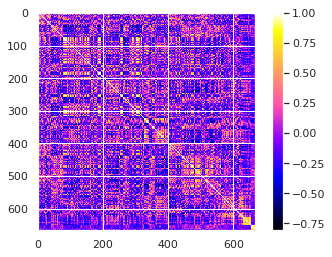

In [96]:
plot_sim_matrix_dbscan(X_removed_nor, pred_d_3)

### with X_pca data

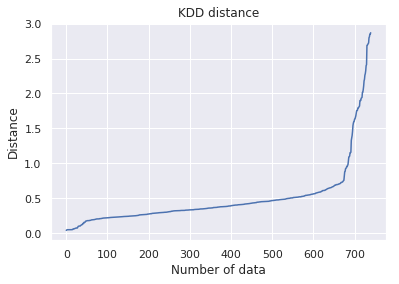

In [97]:
# Try k = 20
plot_knn_distance(X_pca, k=20)

Time taken:  0.61223
% instances per cluster:  [0.93513514]
% of noise:  0.06486486486486487


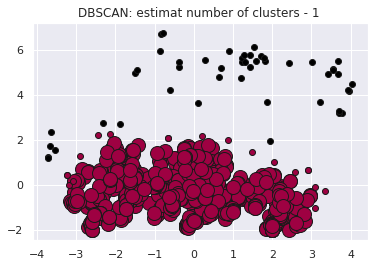

In [98]:
# choose eps=0.75, min sample=20
t1_d_2 = datetime.now()
d_2 = DBSCAN(eps=0.75, min_samples=20)
pred_d_2 = d_2.fit_predict(X_pca)
t2_d_2 = datetime.now()
print("Time taken: ", (t2_d_2-t1_d_2).microseconds/100000 + (t2_d_2 - t1_d_2).seconds)
d_2_ls = np.array([x for x in pred_d_2 if x!=-1])
print("% instances per cluster: ", np.bincount(d_2_ls)/len(pred_d_2))
print("% of noise: ", (len(pred_d_2) - len(d_2_ls))/len(pred_d_2))
plot_dbscan(X_pca, d_2)

In [99]:
detail_each_cluster(pred_d_2).iloc[:, [11, 15, 20]]

,Disciplinary failure,Social smoker,Absenteeism time in hours
cluster label,,,
-1,0.833333,0.187500,0.812500
0,0.000000,0.065029,7.348266


### with X_supervised data

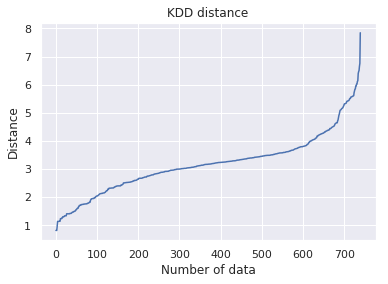

In [100]:
# Try k = 15
plot_knn_distance(X_supervised, k=15)

Time taken:  0.30241
% instances per cluster:  [0.86351351 0.03513514 0.02162162]
% of noise:  0.07972972972972973


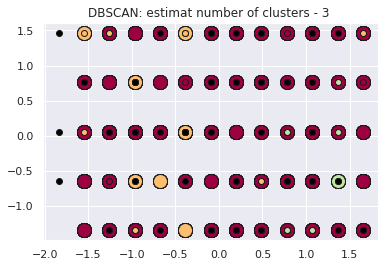

In [101]:
# choose eps=4, min sample=15
t1_d_4 = datetime.now()
d_4 = DBSCAN(eps=4, min_samples=15)
pred_d_4 = d_4.fit_predict(X_supervised)
t2_d_4 = datetime.now()
print("Time taken: ", (t2_d_4-t1_d_4).microseconds/100000 + (t2_d_4 - t1_d_4).seconds)
d_4_ls = np.array([x for x in pred_d_4 if x!=-1])
print("% instances per cluster: ", np.bincount(d_4_ls)/len(pred_d_4))
print("% of noise: ", (len(pred_d_4) - len(d_4_ls))/len(pred_d_4))
plot_dbscan(X_supervised, d_4)

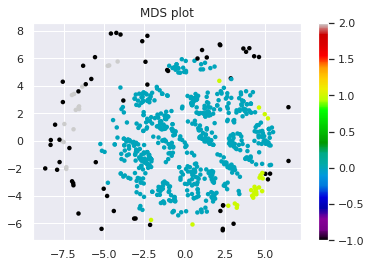

In [102]:
# Plot MDS
plot_mds(X_supervised, pred_d_4)

In [103]:
n_d_4 = len(set(d_4.labels_)) - (1 if -1 in d_4.labels_ else 0)
if(n_d_4!=1):
    true_lab = KBinsDiscretizer(n_bins=n_d_4, encode="ordinal", strategy="quantile").fit_transform(X[[pred_d_4!=-1, -1]].reshape(-1, 1))
    true_lab = true_lab.ravel()
    r_d_4 = adjusted_rand_score(true_lab, pred_d_4[pred_d_4!=-1])
    nmi_d_4 = normalized_mutual_info_score(true_lab, pred_d_4[pred_d_4!=-1])
    print(r_d_4)
    print(nmi_d_4)
else:
    print(1)
    print(1)

0.03697431973699959
0.09225174804334983


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [104]:
detail_d_4 = detail_each_cluster(pred_d_4)

In [105]:
detail_d_4

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
cluster label,,,,,,,,,,,,,,,,,,,,,
-1,18.847458,0.779661,6.457627,4.050847,2.338983,253.627119,32.847458,11.830508,39.152542,276.981593,93.711864,0.40678,1.186441,1.084746,0.593220,0.474576,2.474576,81.474576,173.949153,26.966102,2.830508
0,17.965571,1.644757,6.303599,3.902973,2.532081,218.935837,29.809077,12.436620,35.992175,270.942567,94.672926,0.00000,1.287950,0.959311,0.574335,0.000000,0.619718,79.317684,172.051643,26.785603,7.391236
1,16.115385,1.346154,4.769231,4.192308,2.500000,190.500000,19.653846,17.038462,40.461538,280.683115,96.192308,0.00000,1.769231,2.000000,0.230769,1.000000,0.038462,65.038462,170.346154,22.576923,9.000000
2,20.125000,0.000000,9.187500,3.437500,3.875000,247.937500,26.875000,12.625000,38.250000,258.174938,91.812500,1.00000,1.062500,1.562500,0.750000,0.000000,0.562500,81.500000,170.750000,27.937500,0.000000
